In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
# from snowflake.connector.pandas_tools import write_pandas
# from sqlalchemy import create_engine
import snowflake.connector

from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

from snowflake.connector.pandas_tools import write_pandas

d:\Users\ksbha\miniconda3\envs\footy\Lib\site-packages\snowflake\connector\options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (14.0.2), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(
Failed to import ArrowResult. No Apache Arrow result set format can be used. ImportError: DLL load failed while importing arrow_iterator: The specified procedure could not be found.


In [2]:
import snowflake.connector

In [3]:
## Set options to view all columns
pd.set_option('display.max_columns', None)

In [32]:
SNOWFLAKE_USER = 'kbharaj3'
SNOWFLAKE_PASSWORD = 'Snowfl@key0014'
SNOWFLAKE_ACCOUNT = 'qx25653.ca-central-1.aws'
SNOWFLAKE_WAREHOUSE = 'FOOTY_STORE'
SNOWFLAKE_DATABASE = 'GEGENSTATS'
SNOWFLAKE_SCHEMA = 'TABLES'

In [33]:
conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA
)

In [27]:
cursor = conn.cursor()

In [7]:
def fetch_data(cursor, query):
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]
    return pd.DataFrame(rows, columns=column_names)

In [8]:
team_names = fetch_data(cursor, 'SELECT * FROM TEAMS')

In [9]:
team_misc = fetch_data(cursor, 'SELECT * FROM TEAM_MISC_STATS')

In [10]:
team_standard = fetch_data(cursor, 'SELECT * FROM TEAM_STANDARD_STATS')

In [11]:
team_attacking = fetch_data(cursor, 'SELECT * FROM TEAM_ATTACKING_STATS')

In [12]:
team_defending = fetch_data(cursor, 'SELECT * FROM TEAM_DEFENDING_STATS')

In [13]:
df_competitions = fetch_data(cursor, 'SELECT COMPETITION, COMPETITION_ACRONYM, SEASON FROM COMPETITIONS')

In [14]:
df_matches = fetch_data(cursor, 'SELECT * FROM MATCHES')

In [15]:
df_shots = fetch_data(cursor, 'SELECT * FROM SHOT_EVENTS')

In [18]:
team_misc.isna().sum()

TEAM_FBREF_ID    0
SEASON           0
COMPETITION      0
AERIALS_WON      0
AERIALS_LOST     0
dtype: int64

In [21]:
data = {
    "COMPETITION": [
        "FRA-Ligue 1",
        "ITA-Serie A",
        "GER-Bundesliga",  
        "ESP-La Liga", 
    ],
    "COMPETITION_NAME": [
        "Ligue 1 Uber Eats", 
        "Serie A Tim", 
        "1. Bundesliga", 
        "LaLiga EA Sports",
    ],
    "COMPETITION_ACRONYM": [
        "Ligue 1", 
        "Serie A", 
        "Bundesliga", 
        "LALIGA",
    ],
    "SEASON": [
        2324,
        2324,
        2324,
        2324, 
    ]
}

df = pd.DataFrame(data)

In [34]:
df

,COMPETITION,COMPETITION_NAME,COMPETITION_ACRONYM,SEASON
0,FRA-Ligue 1,Ligue 1 Uber Eats,Ligue 1,2324
1,ITA-Serie A,Serie A Tim,Serie A,2324
2,GER-Bundesliga,1. Bundesliga,Bundesliga,2324
3,ESP-La Liga,LaLiga EA Sports,LALIGA,2324


In [35]:
cur = conn.cursor()
cur.execute(f"USE WAREHOUSE {SNOWFLAKE_WAREHOUSE}")

In [36]:
upsert_to_snowflake("COMPETITIONS", df, ['COMPETITION', 'SEASON'])

Upsert completed. 4 rows processed.


In [17]:
df_competitions

,COMPETITION,COMPETITION_ACRONYM,SEASON
0,FRA-Ligue 1,Ligue 1,2223
1,FRA-Ligue 1,Ligue 1,2122
2,ITA-Serie A,Serie A,2223
3,ITA-Serie A,Serie A,2122
4,GER-Bundesliga,Bundesliga,2223
5,GER-Bundesliga,Bundesliga,2122
6,ESP-La Liga,LALIGA,2223
7,ESP-La Liga,LALIGA,2122
8,ENG-Premier League,EPL,2122
9,ENG-Premier League,EPL,2324


In [16]:
team_misc = team_misc.merge(df_competitions, on=['COMPETITION','SEASON'], how='left')

team_misc = team_misc.merge(team_names, on='TEAM_FBREF_ID', how='left')

team_misc = team_misc.merge(team_standard, on=['TEAM_FBREF_ID', 'SEASON', 'COMPETITION'], how='left')

In [17]:
team_attacking.isna().sum()

TEAM_FBREF_ID        0
SEASON               0
COMPETITION          0
GOALS_SCORED         0
NPXG                 0
XG                   0
SHOTS                0
SHOTS_ON_TARGET      0
PASS_COMPLETED       0
PASS_ATTEMPTED       0
TAKEONS_ATTEMPTED    0
TAKEONS_COMPLETED    0
CROSSES_INTO_PA      0
FOULS_AGAINST        0
dtype: int64

In [18]:
team_misc['AERIAL DUELS WON RATIO (%)'] = team_misc['AERIALS_WON']*100/(team_misc['AERIALS_WON'] + 
                                                                team_misc['AERIALS_LOST'])
team_misc['AERIAL DUELS ATTEMPTED PER GAME'] = (team_misc['AERIALS_WON'] + 
                                           team_misc['AERIALS_LOST'])/team_misc['MATCHES_PLAYED']

In [19]:
x_min_aerial = (team_misc['AERIAL DUELS WON RATIO (%)'].min() // 5)*5
x_max_aerial = (team_misc['AERIAL DUELS WON RATIO (%)'].max()//5)*5 + 5
y_min_aerial = (team_misc['AERIAL DUELS ATTEMPTED PER GAME'].min()//5)*5
y_max_aerial = (team_misc['AERIAL DUELS ATTEMPTED PER GAME'].max()//5)*5 + 5

In [20]:
## Old limits: (45.0, 60.0, 20.0, 35.0)

In [21]:
team_misc.shape

(292, 17)

In [22]:
team_goal_output = team_standard.merge(team_defending[['TEAM_FBREF_ID', 'SEASON', 'COMPETITION', 'XG_AGAINST']], 
                                       on=['TEAM_FBREF_ID', 'SEASON', 'COMPETITION'], how='inner')

team_goal_output = team_goal_output.merge(df_competitions[['COMPETITION','COMPETITION_ACRONYM','SEASON']], 
                                      on=['COMPETITION','SEASON'], how='inner')

team_goal_output = team_goal_output.merge(team_attacking[['TEAM_FBREF_ID', 'SEASON', 'COMPETITION','NPXG']], 
                                          on=['TEAM_FBREF_ID', 'SEASON', 'COMPETITION'], how='inner')

In [23]:
team_goal_output['EXPECTED GOALS AGAINST PER GAME'] = team_goal_output['XG_AGAINST']/team_goal_output['MATCHES_PLAYED']
team_goal_output['NON PENALTY EXPECTED GOALS PER GAME'] = team_goal_output['NPXG']/team_goal_output['MATCHES_PLAYED']

In [24]:
team_goal_output = team_goal_output.merge(team_names, on='TEAM_FBREF_ID', how='left')

In [25]:
team_defending['BLOCKS'] = team_defending['BLOCKED_SHOTS'] + team_defending['BLOCKED_PASSES']

In [26]:
team_defending_chart = team_standard.merge(team_defending[['TEAM_FBREF_ID', 'SEASON', 'COMPETITION', 'BLOCKS', 'CLEARANCES',
                                                           'GOALS_CONCEDED', 'SHOTS_FACED', 'TACKLES', 'TACKLES_WON']], 
                                       on=['TEAM_FBREF_ID', 'SEASON', 'COMPETITION'], how='left')

team_defending_chart = team_defending_chart.merge(df_competitions[['COMPETITION','COMPETITION_ACRONYM','SEASON']], 
                                      on=['COMPETITION','SEASON'], how='left')

team_defending_chart = team_defending_chart.merge(team_names, on='TEAM_FBREF_ID', how='left')

In [28]:
team_defending_chart['BLOCKS PER GAME'] = team_defending_chart['BLOCKS']/team_defending_chart['MATCHES_PLAYED']
team_defending_chart['CLEARANCES PER GAME'] = team_defending_chart['CLEARANCES']/team_defending_chart['MATCHES_PLAYED']
team_defending_chart['SHOTS FACED PER GAME'] = team_defending_chart['SHOTS_FACED']/team_defending_chart['MATCHES_PLAYED']
team_defending_chart['OPPOSITION CONVERSION RATE (%)'] = (team_defending_chart['GOALS_CONCEDED']/team_defending_chart['SHOTS_FACED'])*100
team_defending_chart['CONCEDED PER GAME'] = team_defending_chart['GOALS_CONCEDED']/team_defending_chart['MATCHES_PLAYED']
team_defending_chart['TACKLES ATTEMPTED PER GAME'] = team_defending_chart['TACKLES']/team_defending_chart['MATCHES_PLAYED']
team_defending_chart['TACKLES WON RATIO (%)'] = (team_defending_chart['TACKLES_WON']/team_defending_chart['TACKLES'])*100

In [29]:
SNOWFLAKE_SCHEMA = 'RADAR_CHARTS'

In [30]:
conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA
    )

In [31]:
cur = conn.cursor()
cur.execute(f"USE WAREHOUSE {SNOWFLAKE_WAREHOUSE}")

In [32]:
create_schema_sql = f"CREATE SCHEMA IF NOT EXISTS {SNOWFLAKE_SCHEMA}"
cur.execute(create_schema_sql)

In [33]:
create_table_query = """
CREATE TABLE IF NOT EXISTS TEAM_GOAL_OUTPUT (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    EXPECTED_GOALS_AGAINST_PER_GAME FLOAT,
    NON_PENALTY_EXPECTED_GOALS_PER_GAME FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [ ]:
cur.execute(create_table_query)

In [ ]:
create_table_query = """
CREATE TABLE IF NOT EXISTS TEAM_DEFENDING_CHART (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    BLOCKS_PER_GAME FLOAT,
    CLEARANCES_PER_GAME FLOAT,
    SHOTS_FACED_PER_GAME FLOAT,
    OPPOSITION_CONVERSION_RATE FLOAT,
    CONCEDED_PER_GAME FLOAT,
    TACKLES_ATTEMPTED_PER_GAME FLOAT,
    TACKLES_WON_RATIO FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [ ]:
cur.execute(create_table_query)

In [25]:
def upsert_to_snowflake(table_name, dataframe, primary_keys):
    if isinstance(primary_keys, str):
        primary_keys = [primary_keys]

    temp_table_name = f"{table_name}_TEMP"
    success, nchunks, nrows, _ = write_pandas(conn, dataframe, temp_table_name, auto_create_table=True)

    on_condition = ' AND '.join([f"{table_name}.{pk} = {temp_table_name}.{pk}" for pk in primary_keys])

    update_columns = [col for col in dataframe.columns if col not in primary_keys]
    update_sql = ', '.join([f"{table_name}.{col} = {temp_table_name}.{col}" for col in update_columns])

    merge_sql = f"""
    MERGE INTO {table_name} USING {temp_table_name}
    ON {on_condition}
    """

    if update_columns:
        merge_sql += f"""
        WHEN MATCHED THEN
            UPDATE SET
                {update_sql}
        """

    merge_sql += f"""
    WHEN NOT MATCHED THEN
        INSERT ({', '.join(dataframe.columns)})
        VALUES ({', '.join([f"{temp_table_name}.{col}" for col in dataframe.columns])})
    """

    cur.execute(merge_sql)
    cur.execute(f"DROP TABLE IF EXISTS {temp_table_name}")

    print(f"Upsert completed. {nrows} rows processed.")

In [35]:
team_goal_output.rename(columns={'EXPECTED GOALS AGAINST PER GAME':'EXPECTED_GOALS_AGAINST_PER_GAME',
                                 'NON PENALTY EXPECTED GOALS PER GAME':'NON_PENALTY_EXPECTED_GOALS_PER_GAME'}, inplace=True)

In [36]:
team_goal_output[team_goal_output['XG_AGAINST'].isna()]

,TEAM_FBREF_ID,SEASON,COMPETITION,MATCHES_PLAYED,TEAM_WINS,TEAM_DRAWS,TEAM_LOSSES,TEAM_PTS,TEAM_XPTS,XG_AGAINST,COMPETITION_ACRONYM,NPXG,EXPECTED_GOALS_AGAINST_PER_GAME,NON_PENALTY_EXPECTED_GOALS_PER_GAME,TEAM_NAME,TEAM_LOGO_URL,TEAM_WS_ID


In [34]:
upsert_to_snowflake("TEAM_GOAL_OUTPUT", team_goal_output[['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME', 'TEAM_LOGO_URL',
                    'EXPECTED_GOALS_AGAINST_PER_GAME', 'NON_PENALTY_EXPECTED_GOALS_PER_GAME']],
                    ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

ProgrammingError: 002003 (42S02): SQL compilation error:
Object 'TEAM_GOAL_OUTPUT' does not exist or not authorized.

In [37]:
team_defending_chart.columns = team_defending_chart.columns.str.replace(" ", "_")

In [38]:
team_defending_chart.rename(columns={'TACKLES_WON_RATIO_(%)':'TACKLES_WON_RATIO',
                                     'OPPOSITION_CONVERSION_RATE_(%)':'OPPOSITION_CONVERSION_RATE'}, inplace=True)

In [39]:
team_defending_chart.shape

(292, 26)

In [ ]:
upsert_to_snowflake("TEAM_DEFENDING_CHART", team_defending_chart[['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME', 'TEAM_LOGO_URL',
                    'BLOCKS_PER_GAME', 'CLEARANCES_PER_GAME', 'SHOTS_FACED_PER_GAME', 'OPPOSITION_CONVERSION_RATE',
                    'CONCEDED_PER_GAME', 'TACKLES_ATTEMPTED_PER_GAME', 'TACKLES_WON_RATIO']],
                    ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

In [40]:
SNOWFLAKE_SCHEMA

'RADAR_CHARTS'

In [41]:
cur = conn.cursor()

In [42]:
team_defending_chart = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.TEAM_DEFENDING_CHART')

In [43]:
team_goal_output = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.TEAM_GOAL_OUTPUT')

In [44]:
team_defending_chart.rename(columns={'BLOCKS_PER_GAME':'BLOCKS PER GAME', 'CLEARANCES_PER_GAME':'CLEARANCES PER GAME',
                                    'SHOTS_FACED_PER_GAME':'SHOTS FACED PER GAME', 'OPPOSITION_CONVERSION_RATE':'OPPOSITION CONVERSION RATE (%)',
                                    'CONCEDED_PER_GAME':'CONCEDED PER GAME', 'TACKLES_ATTEMPTED_PER_GAME':'TACKLES ATTEMPTED PER GAME',
                                    'TACKLES_WON_RATIO':'TACKLES WON RATIO (%)'}, inplace=True)

In [45]:
team_goal_output.rename(columns={'EXPECTED_GOALS_AGAINST_PER_GAME':'EXPECTED GOALS AGAINST PER GAME',
                                'NON_PENALTY_EXPECTED_GOALS_PER_GAME':'NON PENALTY EXPECTED GOALS PER GAME'}, inplace=True)

In [46]:
def create_FM_team_scatter_chart(df, chart_name, team_name, x_axis_label, y_axis_label, img_size, x_min, x_max, y_min, y_max, bottom_left_label, 
                                 bottom_right_label, top_left_label, top_right_label, bl_color, br_color, tl_color, tr_color):
    fig = go.Figure()
    x_axis_mean_val = df[x_axis_label].mean()
    y_axis_mean_val = df[y_axis_label].mean()

    # Add the scatter plot points
    for index, row in df.iterrows():
        fig.add_trace(go.Scatter(
            x=[row[x_axis_label]],
            y=[row[y_axis_label]],
            mode='markers',
            text=row["TEAM_NAME"],
            marker=dict(
                opacity=0
            ),
            hoverinfo='text',
        ))

        # Add team logo as a layout_image
        fig.add_layout_image(
            dict(
                source=row["TEAM_LOGO_URL"],
                x=row[x_axis_label],
                y=row[y_axis_label],
                xref="x",
                yref="y",
                xanchor="center",
                yanchor="middle"
            )
        )


    # Update axes and layout as necessary
    # ...
        
    fig.update_xaxes(range=[x_min, x_max], title=x_axis_label)
    fig.update_yaxes(range=[y_min, y_max], title=y_axis_label)

    fig.add_shape(
        type='line',
        x0=x_axis_mean_val, y0=fig.layout.yaxis.range[0],  # start of the line
        x1=x_axis_mean_val, y1=fig.layout.yaxis.range[1],  # end of the line
        line=dict(color='White', width=3),
        layer='below'
    )

    # Add a horizontal line at the mean aerials attempted per game
    fig.add_shape(
        type='line',
        x0=fig.layout.xaxis.range[0], y0=y_axis_mean_val,  # start of the line
        x1=fig.layout.xaxis.range[1], y1=y_axis_mean_val,  # end of the line
        line=dict(color='White', width=3),
        layer='below'
    )

    fig.update_layout(
        width=625,
        height=625,
        showlegend=False,
        paper_bgcolor='rgb(70, 70, 70)',
        plot_bgcolor='rgb(70, 70, 70)',
        font=dict(
                family="Roboto, sans-serif",  # Specify the font family
                size=25,                     # Specify the font size
                color="white"                # Specify the font color
            ),
        hoverlabel=dict(
                bgcolor="rgba(20, 20, 20, 0.8)",
                font_family="Roboto, sans-serif"),
        title={
            'text': f'{chart_name}',
            'y':0.98,  # Sets the y position of the title (1 is the top of the figure)
            'x':0.5,  # Centers the title horizontally (0.5 is the center of the figure)
            'xanchor': 'center',  # Ensures the title is centered at the x position
            'yanchor': 'top',  # Ensures the title is at the top of the y position
            'font': dict(
                family="Roboto, sans-serif",  # Specify the font family
                size=23,                     # Specify the font size
                color="white"                # Specify the font color
            )
        },
        margin=dict(l=10, r=30, t=50, b=10),
        images= [dict(
            source= row["TEAM_LOGO_URL"],
            xref="x",
            yref="y",
            x= row[x_axis_label],
            y= row[y_axis_label],
            sizex=img_size*1.8 if row['TEAM_NAME'] == team_name else img_size,  # The size of the image in x axis units
            sizey=img_size*1.8 if row['TEAM_NAME'] == team_name else img_size,  # The size of the image in y axis units
            sizing="contain",
            opacity=1 if row['TEAM_NAME'] == team_name else 0.35,
            layer="above") for index, row in df.iterrows()]
    )

    fig.update_xaxes(
        title=dict(font=dict(size=25)),
        showline=True,  # Show the axis line
        linewidth=2,  # Width of the axis line
        linecolor='white',  # Color of the axis line
        gridcolor='rgba(0,0,0,0)',  # Set grid line color to transparent
        tickfont=dict(color='white', size=15),  # Set the color of the axis ticks (numbers)
    )

    fig.update_yaxes(
        title=dict(font=dict(size=25)),
        showline=True,
        linewidth=2,
        linecolor='white',
        gridcolor='rgba(0,0,0,0)',
        tickfont=dict(color='white', size=15),
    )

    fig.add_annotation(text=bottom_left_label,
                    xref="paper", yref="paper",
                    x=0, y=0,  # Bottom left corner
                    showarrow=False,
                    font=dict(size=15, color=bl_color, family="Roboto, sans-serif"),
                    align="left")

    fig.add_annotation(text=top_left_label,
                    xref="paper", yref="paper",
                    x=0, y=1,  # Top left corner
                    showarrow=False,
                    font=dict(size=15, color=tl_color, family="Roboto, sans-serif"),
                    align="left")

    fig.add_annotation(text=top_right_label,
                    xref="paper", yref="paper",
                    x=1, y=1,  # Top right corner
                    showarrow=False,
                    font=dict(size=15, color=tr_color, family="Roboto, sans-serif"),
                    align="right")

    fig.add_annotation(text=bottom_right_label,
                    xref="paper", yref="paper",
                    x=1, y=0,  # Bottom right corner
                    showarrow=False,
                    font=dict(size=15, color=br_color, family="Roboto, sans-serif"),
                    align="right")

    return fig

In [47]:
league_selected = 'Serie A'
season_selected = 2324

In [48]:
filtered_team_misc = team_misc[team_misc['SEASON'] == season_selected]
filtered_team_misc = filtered_team_misc[filtered_team_misc['COMPETITION_ACRONYM'] == league_selected]
filtered_team_goal_output = team_goal_output[team_goal_output['SEASON'] == season_selected]
filtered_team_goal_output = filtered_team_goal_output[filtered_team_goal_output['COMPETITION_ACRONYM'] == league_selected]
filtered_team_defending_chart = team_defending_chart[team_defending_chart['SEASON'] == season_selected]
filtered_team_defending_chart = filtered_team_defending_chart[filtered_team_defending_chart['COMPETITION_ACRONYM'] == league_selected]

filtered_matches = df_matches[df_matches['SEASON'] == season_selected]

In [51]:
create_FM_team_scatter_chart(filtered_team_misc, 'AERIAL', "Arsenal", 'AERIAL DUELS WON RATIO (%)', 'AERIAL DUELS ATTEMPTED PER GAME', 
                                                            1.45, x_min_aerial, x_max_aerial, y_min_aerial, y_max_aerial, 
                                                            "Fewer Duels<br>Poor Dueling", "Fewer Duels<br>Strong Dueling",
                                                            "Lots of Duels<br>Poor Dueling", "Lots of Duels<br>Strong Dueling", "red", 
                                                            "orange", "orange", "green")

In [44]:
x_min_goal_output = 0.45
x_max_goal_output = 2.60
y_min_goal_output = 0.5
y_max_goal_output = 3.0

In [45]:
create_FM_team_scatter_chart(filtered_team_goal_output, 'GOAL OUTPUT', "Arsenal", 'EXPECTED GOALS AGAINST PER GAME', 'NON PENALTY EXPECTED GOALS PER GAME', 
                            0.1, x_min_goal_output, x_max_goal_output, y_min_goal_output, y_max_goal_output, 
                            "Low non-penalty expected goals<br>Strong Defending", "Low non-penalty expected goals<br>Poor Defending",
                            "High non-penalty expected goals<br>Strong Defending", "High non-penalty expected goals<br>Poor Defending", 
                            "orange", "red", "green", "orange")

In [46]:
create_FM_team_scatter_chart(filtered_team_defending_chart, 'DEFENDING', "Arsenal", 'CLEARANCES PER GAME', 'BLOCKS PER GAME', 
                            1.0, 9, 30, 6, 16, 
                            "Fewer blocks<br>Fewer Clearances", "Fewer blocks<br>Lots of Clearances",
                            "Lots of blocks<br>Fewer Clearances", "Fewer blocks<br>Lots of Clearances", 
                            "red", "orange", "orange", "green")

In [47]:
create_FM_team_scatter_chart(filtered_team_defending_chart, 'DEFENSIVE EFFICIENCY', "Arsenal", 'OPPOSITION CONVERSION RATE (%)', 
                             'SHOTS FACED PER GAME', 0.7, 4.0, 18.5, 5.5, 18.5, 
                            # 0.85, 7, 30, 4, 18, 
                            "Quiet defence<br>Impenetrable defence", "Quiet defence<br>Leaky defence", 
                            "Busy defence<br>Impenetrable defence", "Busy defence<br>Leaky defence", 
                            "green", "orange", "orange", "red")

In [48]:
create_FM_team_scatter_chart(filtered_team_defending_chart, 'GOALKEEPING', "Arsenal", 'SHOTS FACED PER GAME', 
                             'CONCEDED PER GAME', 0.55, 5.5, 18.5, 0.4, 2.75,
                            "Impenetrable defence<br>Quiet defence", "Impenetrable defence<br>Busy defence", 
                            "Leaky defence<br>Quiet defence", "Leaky defence<br>Busy defence", 
                            "green", "orange", "orange", "red")

In [49]:
create_FM_team_scatter_chart(filtered_team_defending_chart, 'TACKLING', "Arsenal", 'TACKLES WON RATIO (%)', 'TACKLES ATTEMPTED PER GAME', 
                                                            0.7, 52, 68, 11, 23, 
                                                            "Fewer Duels<br>Poor Dueling", "Fewer Duels<br>Strong Dueling",
                                                            "Lots of Duels<br>Poor Dueling", "Lots of Duels<br>Strong Dueling", "red", 
                                                            "orange", "orange", "green")


### Time to incorporate event data for additional graphs

In [50]:
df_player_match = fetch_data(cursor, 'SELECT PLAYER_WS_ID, MATCH_ID, PLAYER_FBREF_NAME, \
                             STARTING_POSITION_WS FROM PLAYER_MATCH')

In [51]:
df_events = fetch_data(cursor, 'SELECT * FROM EVENTS_SPADL')

In [52]:
# df_events = df_events[df_events['MATCH_ID'].isin(list(filtered_matches.MATCH_ID))]

In [53]:
df_events = df_events.merge(df_matches[['MATCH_ID','COMPETITION','SEASON']], on='MATCH_ID', how='left')

In [54]:
defensive_events = df_events[df_events['TYPE_NAME'].isin(['tackle', 'foul', 'interception','clearance'])]

In [55]:
defensive_events = defensive_events.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on='TEAM_FBREF_ID')
defensive_events = defensive_events.merge(df_player_match, on=['PLAYER_WS_ID', 'MATCH_ID'])

In [56]:
interest_pos = ['DL', 'DC', 'DR']
defender_defend_actions = defensive_events[defensive_events['STARTING_POSITION_WS'].isin(interest_pos)]

In [57]:
grouped_def_action_team = defender_defend_actions[['TEAM_NAME','COMPETITION','SEASON',
                                                   'START_X']].groupby(['TEAM_NAME','COMPETITION','SEASON']).mean()

In [58]:
team_defending = team_defending.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID', 'TEAM_LOGO_URL']], on='TEAM_FBREF_ID')

In [59]:
grouped_OPPDA = team_defending[['TEAM_NAME','TEAM_LOGO_URL','COMPETITION','SEASON',
                                'OPP_PPDA']].groupby(['COMPETITION','SEASON','TEAM_NAME','TEAM_LOGO_URL']).mean()

In [60]:
grouped_def_action_team.rename({'START_X':'AVERAGE DEFENSIVE ACTION FROM DEFENDERS (YARDS)'}, axis=1,inplace=True)

In [61]:
grouped_OPPDA = team_defending[['TEAM_NAME','TEAM_LOGO_URL','COMPETITION','SEASON','OPP_PPDA']].groupby(['TEAM_NAME',
                                                        'COMPETITION','SEASON','TEAM_LOGO_URL']).mean()
grouped_def_action_team.rename({'START_X':'AVERAGE DEFENSIVE ACTION FROM DEFENDERS (YARDS)'}, axis=1,inplace=True)
grouped_OPPDA.rename({'OPP_PPDA':'OPPOSITION PASSES PER DEFENSIVE ACTION'}, axis=1,inplace=True)
pressing_intensity_chart = pd.merge(grouped_def_action_team.reset_index(), grouped_OPPDA.reset_index(), on=['TEAM_NAME', 
                                                                            'COMPETITION','SEASON'])
pressing_intensity_chart.reset_index(inplace=True, drop=True)

In [62]:
pressing_intensity_chart = pressing_intensity_chart.merge(df_competitions, on=['COMPETITION','SEASON'])

In [63]:
pressing_intensity_chart.drop(['COMPETITION'], axis=1, inplace=True)

In [ ]:
create_table_query = """
CREATE TABLE IF NOT EXISTS PRESSING_INTENSITY_CHART (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    AVERAGE_DEFENSIVE_ACTION_FROM_DEFENDERS FLOAT,
    OPPOSITION_PASSES_PER_DEFENSIVE_ACTION FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [ ]:
cur.execute(create_table_query)

In [64]:
pressing_intensity_chart.columns = pressing_intensity_chart.columns.str.replace(" ", "_")

In [65]:
pressing_intensity_chart.rename(columns={'AVERAGE_DEFENSIVE_ACTION_FROM_DEFENDERS_(YARDS)':'AVERAGE_DEFENSIVE_ACTION_FROM_DEFENDERS'}, inplace=True)

In [ ]:
upsert_to_snowflake("PRESSING_INTENSITY_CHART", pressing_intensity_chart[['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME', 'TEAM_LOGO_URL',
                    'AVERAGE_DEFENSIVE_ACTION_FROM_DEFENDERS', 'OPPOSITION_PASSES_PER_DEFENSIVE_ACTION']],
                    ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

In [66]:
pressing_intensity_chart = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.PRESSING_INTENSITY_CHART')

In [67]:
pressing_intensity_chart.rename(columns={'AVERAGE_DEFENSIVE_ACTION_FROM_DEFENDERS':'AVERAGE DEFENSIVE ACTION FROM DEFENDERS (YARDS)',
                                         'OPPOSITION_PASSES_PER_DEFENSIVE_ACTION':'OPPOSITION PASSES PER DEFENSIVE ACTION'}, inplace=True)

In [68]:
filt_pressing_intensity_chart = pressing_intensity_chart[pressing_intensity_chart['SEASON'] == season_selected]
filt_pressing_intensity_chart = filt_pressing_intensity_chart[filt_pressing_intensity_chart['COMPETITION_ACRONYM'] == league_selected]

In [69]:
create_FM_team_scatter_chart(filt_pressing_intensity_chart, 'PRESSING INTENSITY', "AC Milan", 'AVERAGE DEFENSIVE ACTION FROM DEFENDERS (YARDS)', 
                                                        'OPPOSITION PASSES PER DEFENSIVE ACTION', 0.6, 20, 35, 6, 24, 
                                                        "Low PPDA from Opposition<br>Defenders Defending Deeper", 
                                                        "Low PPDA from Opposition<br>Defenders Defending Higher",
                                                        "High PPDA from Opposition<br>Defenders Defending Deeper", 
                                                        "High PPDA from Opposition<br>Defenders Defending Higher", "red", "orange", "orange", "green")


### Now to look at set_piece crosses

In [70]:
set_piece_cross_events = df_events[df_events['TYPE_NAME'].isin(['freekick_crossed', 'corner_crossed'])]

In [71]:
set_piece_cross_events.loc[:, 'OPPO_TEAM_ID'] = "NaN"

C:\Users\ksbha\AppData\Local\Temp\ipykernel_440392\2166643350.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
# Functio to help us populate the 'OPPO_TEAM_ID' column
def swap_team_id(row, home_id, away_id):
    if row['TEAM_FBREF_ID'] == home_id:
        return away_id
    elif row['TEAM_FBREF_ID'] == away_id:
        return home_id
    else:
        return "PROBLEM"

In [73]:
def specify_oppo_team_id_to_events(df_events, filtered_matches):
    for ind, row in filtered_matches.iterrows():
        home_team_id = row['HOME_TEAM_ID']
        away_team_id = row['AWAY_TEAM_ID']

        inds_to_replace = df_events[df_events['MATCH_ID'] == row['MATCH_ID']].index
        df_events.loc[inds_to_replace, 'OPPO_TEAM_ID'] = df_events.loc[inds_to_replace].apply(swap_team_id, 
                                                                                             axis=1, args=(home_team_id, away_team_id))
    return df_events

In [74]:
set_piece_cross_events = specify_oppo_team_id_to_events(set_piece_cross_events, df_matches)

In [75]:
team_names_2 = team_names[['TEAM_NAME', 'TEAM_FBREF_ID']].copy()
team_names_2.rename({'TEAM_FBREF_ID':'OPPO_TEAM_ID', 'TEAM_NAME':'OPPO_TEAM_NAME'}, axis=1, inplace=True)

In [76]:
set_piece_cross_events = set_piece_cross_events.merge(team_names_2, on="OPPO_TEAM_ID")

In [77]:
set_piece_cross_events_grouped = set_piece_cross_events[['OPPO_TEAM_NAME','COMPETITION','SEASON','MATCH_ID']].groupby([
    'OPPO_TEAM_NAME','COMPETITION','SEASON']).count()

In [78]:
team_name_matches_played = team_misc[['TEAM_NAME', 'COMPETITION','SEASON','MATCHES_PLAYED']].copy()

In [79]:
set_piece_cross_events_grouped.rename({'MATCH_ID':'OPPOSITION CROSSES FROM SET PIECE'}, axis=1, inplace=True)

In [80]:
set_piece_cross_events_grouped = team_name_matches_played.merge(set_piece_cross_events_grouped.reset_index().rename(
    {'OPPO_TEAM_NAME':'TEAM_NAME'}, axis=1),on=['TEAM_NAME','COMPETITION','SEASON'])

In [81]:
set_piece_cross_events_grouped['OPPOSITION CROSSES FROM SET PIECE PER GAME'] = set_piece_cross_events_grouped['OPPOSITION CROSSES FROM SET PIECE'] / \
                                                                        set_piece_cross_events_grouped['MATCHES_PLAYED']

In [82]:
inds1 = df_shots[df_shots['SCA_1_PLAYER_FBREF_EVENT'].isin(['Pass (Dead)'])].index
inds2 = df_shots[df_shots['SCA_2_PLAYER_FBREF_EVENT'].isin(['Pass (Dead)'])].index

In [83]:
inds_union = np.union1d(inds1, inds2)

In [84]:
df_shots_set_piece = df_shots.loc[inds_union]

In [85]:
df_shots_set_piece = df_events[['MATCH_ID','ACTION_ID','TEAM_FBREF_ID']].merge(df_shots_set_piece, on=['MATCH_ID', 'ACTION_ID'])

In [86]:
df_shots_set_piece.loc[:, 'OPPO_TEAM_ID'] = "NaN"

In [87]:
df_shots_set_piece = specify_oppo_team_id_to_events(df_shots_set_piece, df_matches)

In [88]:
df_shots_set_piece = df_shots_set_piece.merge(team_names_2, on="OPPO_TEAM_ID")

In [89]:
df_shots_set_piece = df_shots_set_piece.merge(df_matches[['MATCH_ID','COMPETITION','SEASON']], on='MATCH_ID', how='left')

In [90]:
shots_xg_conceded_from_set_pieces_grouped = df_shots_set_piece[['OPPO_TEAM_NAME','COMPETITION','SEASON', 
                                                                'XG']].groupby(['OPPO_TEAM_NAME','COMPETITION','SEASON']).sum()

In [91]:
shots_xg_conceded_from_set_pieces_grouped = team_name_matches_played.merge(shots_xg_conceded_from_set_pieces_grouped.reset_index().rename(
    {'OPPO_TEAM_NAME':'TEAM_NAME'}, axis=1),on=['TEAM_NAME','COMPETITION','SEASON'])

In [92]:
shots_xg_conceded_from_set_pieces_grouped['OPPOSITION XG FROM SET PIECE CROSSES PER GAME'] = shots_xg_conceded_from_set_pieces_grouped['XG'] / \
                                                                        shots_xg_conceded_from_set_pieces_grouped['MATCHES_PLAYED']

In [93]:
set_piece_efficiency_chart = set_piece_cross_events_grouped.drop('MATCHES_PLAYED', 
                                    axis=1).merge(shots_xg_conceded_from_set_pieces_grouped.drop('MATCHES_PLAYED', axis=1), 
                                                                    on=['TEAM_NAME','COMPETITION','SEASON'] )

In [94]:
set_piece_efficiency_chart = set_piece_efficiency_chart.merge(team_names[['TEAM_NAME', 'TEAM_LOGO_URL']], on='TEAM_NAME')

In [95]:
set_piece_efficiency_chart = set_piece_efficiency_chart.merge(df_competitions, on=['COMPETITION','SEASON'])

In [ ]:
set_piece_efficiency_chart.drop(['COMPETITION'], axis=1, inplace=True)

In [ ]:
create_table_query = """
CREATE TABLE IF NOT EXISTS SET_PIECE_EFFICIENCY_CHART (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    OPPOSITION_XG_FROM_SET_PIECE_CROSSES_PER_GAME FLOAT,
    OPPOSITION_CROSSES_FROM_SET_PIECE_PER_GAME FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [ ]:
cur.execute(create_table_query)

In [ ]:
set_piece_efficiency_chart.columns = set_piece_efficiency_chart.columns.str.replace(" ", "_")

In [ ]:
set_piece_efficiency_chart.drop(['OPPOSITION_CROSSES_FROM_SET_PIECE', 'XG'], axis=1, inplace=True)

In [ ]:
upsert_to_snowflake("SET_PIECE_EFFICIENCY_CHART", set_piece_efficiency_chart,
                    ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

In [96]:
set_piece_efficiency_chart = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.SET_PIECE_EFFICIENCY_CHART')

In [97]:
set_piece_efficiency_chart.rename(columns={'OPPOSITION_XG_FROM_SET_PIECE_CROSSES_PER_GAME':'OPPOSITION XG FROM SET PIECE CROSSES PER GAME',
                                            'OPPOSITION_CROSSES_FROM_SET_PIECE_PER_GAME':'OPPOSITION CROSSES FROM SET PIECE PER GAME'}, inplace=True)

In [98]:
filt_set_piece_efficiency_chart = set_piece_efficiency_chart[set_piece_efficiency_chart['SEASON'] == season_selected]
filt_set_piece_efficiency_chart = filt_set_piece_efficiency_chart[filt_set_piece_efficiency_chart['COMPETITION_ACRONYM'] == league_selected]

In [99]:
create_FM_team_scatter_chart(filt_set_piece_efficiency_chart, 'SET PIECE DEFENSIVE EFFICIENCY', "AC Milan", 'OPPOSITION CROSSES FROM SET PIECE PER GAME',
                             'OPPOSITION XG FROM SET PIECE CROSSES PER GAME', 0.4, 2, 14, 0.05, 0.32, 
                                                        "Low xG conceded from crosses<br>Fewer crosses conceded", 
                                                        "Low xG conceded from crosses<br>Many crosses conceded",
                                                        "High xG conceded from crosses<br>Fewer crosses conceded", 
                                                        "High xG conceded from crosses<br>Many crosses conceded", 
                                                        "green", "orange", "orange", "red")


## Plots for the defensive actions per zone

In [100]:
# Define the section boundaries
section_boundaries = [0, 17.5, 35, 52.5, 70, 87.5, 105]

# Split the "START_X" values into sections
defensive_events['Def_Action_Section'] = pd.cut(defensive_events['START_X'], bins=section_boundaries)


In [101]:
defensive_events.isna().sum()

MATCH_ID                0
ORIGINAL_EVENT_ID       0
PERIOD_ID               0
TIME_SECONDS            0
NEW_TIME_SECONDS        0
TEAM_FBREF_ID           0
PLAYER_WS_ID            0
START_X                 0
END_X                   0
START_Y                 0
END_Y                   0
RESULT_ID               0
ACTION_ID               0
TYPE_NAME               0
BODYPART_NAME           0
COMPETITION             0
SEASON                  0
TEAM_NAME               0
PLAYER_FBREF_NAME       0
STARTING_POSITION_WS    0
Def_Action_Section      1
dtype: int64

In [102]:
section_counts = defensive_events.groupby(['COMPETITION', 'SEASON', 'TEAM_NAME', 'Def_Action_Section'])['Def_Action_Section'].count()
section_counts_percentage = (section_counts / section_counts.groupby(['COMPETITION', 'SEASON', 'TEAM_NAME']).transform('sum')) * 100

C:\Users\ksbha\AppData\Local\Temp\ipykernel_440392\114425783.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [103]:
section_counts_percentage = pd.DataFrame(section_counts_percentage).rename({'Def_Action_Section':'COUNT'}, axis=1).reset_index()

In [104]:
section_counts_percentage = section_counts_percentage.dropna(subset=['COUNT'])

In [105]:
section_counts_percentage = section_counts_percentage.pivot(index=['COMPETITION', 'SEASON', 
                                                                   'TEAM_NAME'], columns='Def_Action_Section', values='COUNT')

In [106]:
section_counts_percentage.columns = section_counts_percentage.columns.astype(str)
section_counts_percentage.rename(columns={'(0.0, 17.5]': 'SECTION_1', '(17.5, 35.0]': 'SECTION_2', '(35.0, 52.5]': 'SECTION_3', 
                                          '(52.5, 70.0]': 'SECTION_4', '(70.0, 87.5]': 'SECTION_5', '(87.5, 105.0]': 'SECTION_6'}, 
                                 inplace=True)


In [107]:
section_counts_percentage.dropna(inplace=True)

In [108]:
section_counts_percentage.reset_index(inplace=True)

In [109]:
section_counts_percentage = section_counts_percentage.merge(df_competitions, on=['COMPETITION','SEASON'])

In [110]:
section_counts_percentage.drop(['COMPETITION'], axis=1, inplace=True)

In [ ]:
create_table_query = """
CREATE TABLE IF NOT EXISTS TEAM_DEFENSIVE_ACTIONS (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    SECTION_1 FLOAT,
    SECTION_2 FLOAT,
    SECTION_3 FLOAT,
    SECTION_4 FLOAT,
    SECTION_5 FLOAT,
    SECTION_6 FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [ ]:
cur.execute(create_table_query)

In [ ]:
# section_counts_percentage.rename(columns={'Section_1': 'SECTION_1', 'Section_2': 'SECTION_2', 'Section_3': 'SECTION_3',
#                                             'Section_4': 'SECTION_4', 'Section_5': 'SECTION_5', 'Section_6': 'SECTION_6'}, inplace=True)

In [ ]:
upsert_to_snowflake("TEAM_DEFENSIVE_ACTIONS", section_counts_percentage,
                    ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

In [111]:
section_counts_percentage = fetch_data(cursor, 'SELECT * FROM  GEGENSTATS.RADAR_CHARTS.TEAM_DEFENSIVE_ACTIONS')

In [112]:
league_selected

'Serie A'

In [113]:
section_counts_percentage_filt = section_counts_percentage[section_counts_percentage['SEASON'] == season_selected]
section_counts_percentage_filt = section_counts_percentage_filt[section_counts_percentage_filt['COMPETITION_ACRONYM'] == league_selected]
section_counts_percentage_filt = section_counts_percentage_filt[section_counts_percentage_filt['TEAM_NAME'] == 'AC Milan']

In [114]:
(section_counts_percentage_filt[['SECTION_1', 'SECTION_2', 'SECTION_3', 'SECTION_4', 'SECTION_5', 'SECTION_6']].iloc[0].values)

array([33.26822917, 19.98697917, 16.73177083, 17.05729167,  9.44010417,
        3.515625  ])

In [115]:
def plot_defensive_actions(section_counts_percentage_filt):

    sections = ["(0.0, 17.5]", "(17.5, 35.0]", "(35.0, 52.5]", "(52.5, 70.0]", "(70.0, 87.5]", "(87.5, 105.0]"]
    percentages = (section_counts_percentage_filt[['SECTION_1', 'SECTION_2', 'SECTION_3', 'SECTION_4', 'SECTION_5', 'SECTION_6']].iloc[0].values)

    max_val = math.ceil(max(percentages) / 5) * 5

    def get_green_color(percentage):
        green_intensity = int((percentage / max_val) * 255)
        return f'#00{green_intensity:02x}00'

    pitch = Pitch(pitch_color='#2B2B2B', line_color='white', goal_type='box', pitch_type='uefa', linewidth=1)
    fig, ax = pitch.draw(figsize=(12, 8))

    fig.patch.set_facecolor('#2B2B2B')

    gap_width = 0.3

    for i, percentage in enumerate(percentages):
        start_pos = float(sections[i].split(', ')[0][1:])
        end_pos = float(sections[i].split(', ')[1][:-1])

        if i != 0:  # not the first bar
            start_pos += gap_width

        section_width = end_pos - start_pos
        if i != len(percentages) - 1:  # not the last bar
            section_width -= gap_width

        color = get_green_color(percentage)

        rect = patches.Rectangle((start_pos, 0), section_width, 68,
                                 linewidth=1, edgecolor='black', facecolor=color, alpha=0.6, zorder=2)
        ax.add_patch(rect)

        ax.text(start_pos + section_width / 2, 8, str(percentage.__round__()) + '%', fontproperties='Roboto',
                va='center', ha='center', color='white', fontsize=16, zorder=3)

    scale_height = 3  # Reduced height of the scale rectangles by half
    scale_y_position = -10  # Position of the scale rectangles (negative to be below the pitch)
    scale_length = 105 / 2.5  # Half the pitch length for scale
    scale_start = (105 - scale_length) / 2.25  # Centering the scale

    for i in range(0, max_val + 1, 5):
        start_pos = scale_start + (i / max_val) * scale_length
        section_width = scale_length / (max_val / 5)

        color = get_green_color(i)

        rect = patches.Rectangle((start_pos, scale_y_position), section_width, scale_height,
                                 linewidth=1, edgecolor='black', facecolor=color, alpha=0.6, zorder=2)
        ax.add_patch(rect)

        if i == 0 or i == ((max_val)):
            ax.text(start_pos + (section_width / 2), scale_y_position - (0.5*scale_height),
                    f'{i}%',
                    color='white',
                    fontsize=10,
                    ha='center', va='top',
                    zorder=3)

    ax.set_ylim(bottom=-10)

    plt.title('DEFENSIVE ACTIONS', color='gold', fontsize=20, fontname='Roboto', loc='left')

    return fig



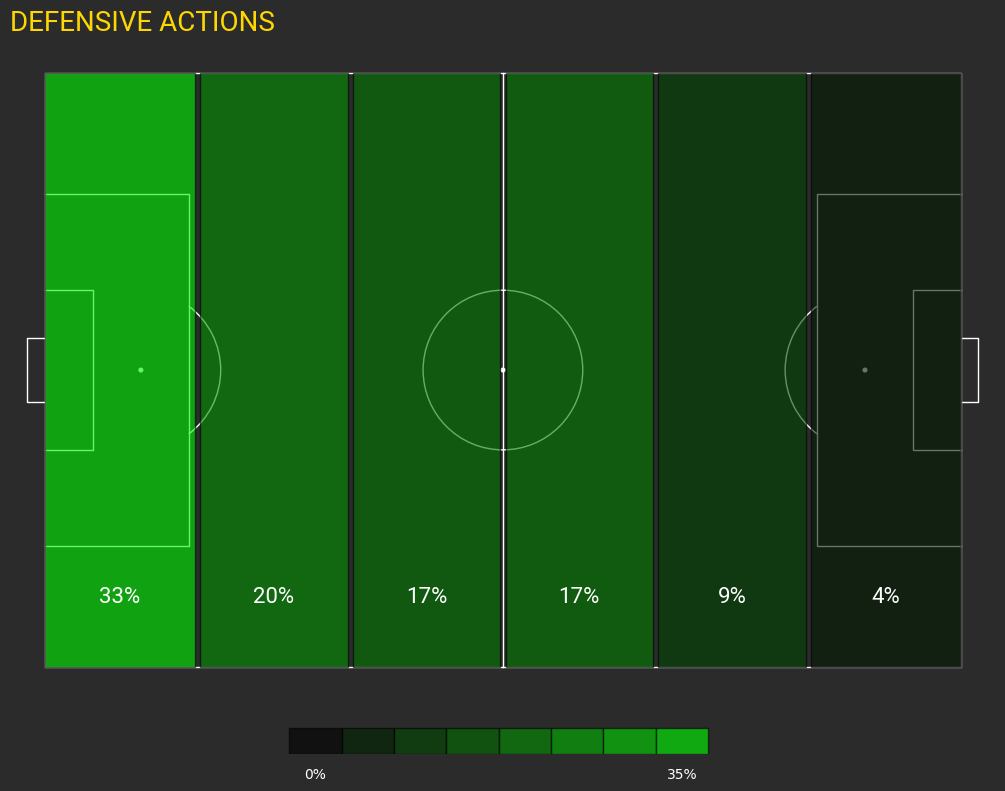

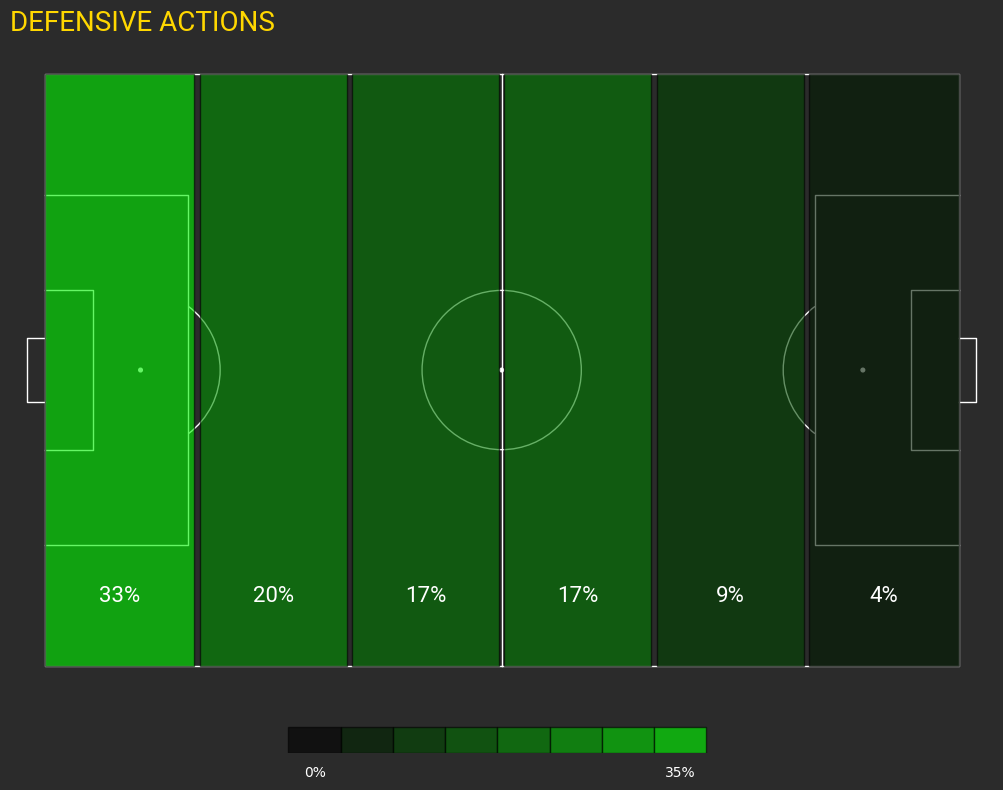

In [116]:
plot_defensive_actions(section_counts_percentage_filt)

# Finally, set-piece data

In [117]:
set_piece_box_deliveries = set_piece_cross_events.copy()

In [118]:
set_piece_box_deliveries.reset_index(drop=True, inplace=True)

In [119]:
## Only interested in crosses that end up in the box
set_piece_box_deliveries = set_piece_box_deliveries[set_piece_box_deliveries['END_X'] >= 88.5]
set_piece_box_deliveries = set_piece_box_deliveries[set_piece_box_deliveries['END_Y'] <= 54.16]
set_piece_box_deliveries = set_piece_box_deliveries[set_piece_box_deliveries['END_Y'] >= 13.84]

In [120]:
## Now, we want to cateogrize each cross as a "near post", "central", or "far post" cross
""" 
If START_Y < 30.34, then:
    - Near post is where END_Y is < 30.34
    - Central is where END_Y is between 30.34 and 37.66
    - Far post is where END_Y is > 37.66

If START_Y > 37.66, then:
    - Near post is where END_Y is > 37.66
    - Central is where END_Y is between 30.34 and 37.66
    - Far post is where END_Y is < 30.34
"""

def classify_cross(row):
    if row['START_Y'] < 34.00:
        if row['END_Y'] < 30.34:
            return 'Near post'
        elif row['END_Y'] > 37.66:
            return 'Far post'
        elif row['END_Y'] >= 30.34 and row['END_Y'] <= 37.66:
            return 'Central'
    elif row['START_Y'] >= 34.0:
        if row['END_Y'] > 37.66:
            return 'Near post'
        elif row['END_Y'] < 30.34:
            return 'Far post'
        elif row['END_Y'] >= 30.34 and row['END_Y'] <= 37.66:
            return 'Central'
    else:
        return 'Not Classified'

In [121]:
set_piece_box_deliveries['Cross_end_location'] = "NaN"
set_piece_box_deliveries['Cross_end_location'] = set_piece_box_deliveries.apply(classify_cross, axis=1)

In [122]:
set_piece_box_deliveries['Cross_end_location'].value_counts()

Cross_end_location
Central      25567
Near post    17493
Far post     12257
Name: count, dtype: int64

In [123]:
filter_1st_contacts = set_piece_box_deliveries[['MATCH_ID', 'ACTION_ID']].copy()
filter_1st_contacts['ACTION_ID'] += 1

In [124]:
set_piece_cross_1st_contacts = df_events.merge(filter_1st_contacts, on=['MATCH_ID', 'ACTION_ID'],how='right')

In [125]:
match_ids_to_remove = set_piece_cross_1st_contacts[set_piece_cross_1st_contacts['TEAM_FBREF_ID'].isna()]['MATCH_ID'].values 
action_ids_to_remove = set_piece_cross_1st_contacts[set_piece_cross_1st_contacts['TEAM_FBREF_ID'].isna()]['ACTION_ID'].values

In [126]:
## Remove missing rows!
for i in range(len(match_ids_to_remove)):
    set_piece_cross_1st_contacts = set_piece_cross_1st_contacts[(set_piece_cross_1st_contacts['MATCH_ID'] != match_ids_to_remove[i]) |
                            (set_piece_cross_1st_contacts['ACTION_ID'] != action_ids_to_remove[i])]
    
    set_piece_box_deliveries = set_piece_box_deliveries[(set_piece_box_deliveries['MATCH_ID'] != match_ids_to_remove[i]) |
                            (set_piece_box_deliveries['ACTION_ID'] != action_ids_to_remove[i]-1)]

In [127]:
set_piece_cross_1st_contacts = specify_oppo_team_id_to_events(set_piece_cross_1st_contacts, df_matches)

In [128]:
set_piece_box_deliveries = specify_oppo_team_id_to_events(set_piece_box_deliveries, df_matches)

In [129]:
set_piece_cross_1st_contacts = set_piece_cross_1st_contacts.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")
set_piece_cross_1st_contacts = set_piece_cross_1st_contacts.merge(team_names_2, on="OPPO_TEAM_ID")

In [130]:
set_piece_box_deliveries = set_piece_box_deliveries.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")
# set_piece_box_deliveries = set_piece_box_deliveries.merge(team_names_2, on="OPPO_TEAM_ID")

In [131]:
set_piece_cross_1st_contacts.sort_values(by=['MATCH_ID', 'ACTION_ID'], inplace=True)
set_piece_cross_1st_contacts.reset_index(drop=True, inplace=True)

In [132]:
set_piece_box_deliveries.sort_values(by=['MATCH_ID', 'ACTION_ID'], inplace=True)
set_piece_box_deliveries.reset_index(drop=True, inplace=True)

In [133]:
set_piece_cross_1st_contacts['Cross_end_location'] = set_piece_box_deliveries['Cross_end_location']

In [134]:
set_piece_same_1st_contacts = set_piece_cross_1st_contacts[set_piece_box_deliveries['TEAM_FBREF_ID'] == set_piece_cross_1st_contacts['TEAM_FBREF_ID']]
set_piece_other_1st_contacts = set_piece_cross_1st_contacts[set_piece_box_deliveries['TEAM_FBREF_ID'] != set_piece_cross_1st_contacts['TEAM_FBREF_ID']]

In [135]:
def_team_lost_1st_contact = set_piece_same_1st_contacts.groupby(['COMPETITION', 'SEASON', 'OPPO_TEAM_NAME', 
                                                                 'Cross_end_location'])['Cross_end_location'].count()

In [136]:
def_team_won_1st_contact = set_piece_other_1st_contacts.groupby(['COMPETITION', 'SEASON', 'TEAM_NAME', 
                                                                 'Cross_end_location'])['Cross_end_location'].count()

In [149]:
def_team_won_1st_contact.shape

(876,)

In [150]:
def_team_lost_1st_contact.shape

(876,)

In [137]:
# def_team_lost_1st_contact = set_piece_same_1st_contacts[set_piece_same_1st_contacts['OPPO_TEAM_NAME'] == 'Arsenal']
# def_team_won_1st_contact = set_piece_other_1st_contacts[set_piece_other_1st_contacts['TEAM_NAME'] == 'Arsenal']

In [138]:
def_set_piece_final = (def_team_won_1st_contact/(def_team_lost_1st_contact+def_team_won_1st_contact))*100

In [139]:
# def_set_piece_final = def_team_won_1st_contact.value_counts('Cross_end_location')/ \
# (def_team_won_1st_contact.value_counts('Cross_end_location')+def_team_lost_1st_contact.value_counts('Cross_end_location'))

In [140]:
def_set_piece_final = pd.DataFrame(def_set_piece_final).rename({'Cross_end_location':'PERC_1ST_CONTACT'}, axis=1).reset_index()

In [141]:
def_set_piece_final.rename(columns={'Cross_end_location':'CROSS_END_LOCATION'}, inplace=True)

In [142]:
def_set_piece_final = def_set_piece_final.merge(df_competitions, on=['COMPETITION','SEASON'])

In [143]:
def_set_piece_final.drop(['COMPETITION'], axis=1, inplace=True)

In [ ]:
create_table_query = """
CREATE TABLE IF NOT EXISTS TEAM_DEF_SET_PIECE_FIRST_CONTACTS (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    PERC_1ST_CONTACT FLOAT,
    CROSS_END_LOCATION VARCHAR(255),
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME, CROSS_END_LOCATION)
);
"""

In [ ]:
cur.execute(create_table_query)

In [ ]:
upsert_to_snowflake("TEAM_DEF_SET_PIECE_FIRST_CONTACTS", def_set_piece_final, ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME',
                                                                            'CROSS_END_LOCATION'])

In [144]:
def_set_piece_final = fetch_data(cursor, 'SELECT * FROM  GEGENSTATS.RADAR_CHARTS.TEAM_DEF_SET_PIECE_FIRST_CONTACTS')

In [145]:
def_set_piece_final

,SEASON,COMPETITION_ACRONYM,TEAM_NAME,PERC_1ST_CONTACT,CROSS_END_LOCATION
0,2122,EPL,Arsenal,80.000000,Central
1,2122,EPL,Arsenal,53.846154,Far post
2,2122,EPL,Arsenal,67.796610,Near post
3,2122,EPL,Aston Villa,73.504274,Central
4,2122,EPL,Aston Villa,40.000000,Far post
...,...,...,...,...,...
871,2324,Serie A,Torino,57.142857,Far post
872,2324,Serie A,Torino,73.809524,Near post
873,2324,Serie A,Udinese,70.270270,Central
874,2324,Serie A,Udinese,63.888889,Far post


In [ ]:
def_set_piece_final_filt = def_set_piece_final[def_set_piece_final['SEASON'] == season_selected]
def_set_piece_final_filt = def_set_piece_final_filt[def_set_piece_final_filt['COMPETITION_ACRONYM'] == league_selected]
def_set_piece_final_filt = def_set_piece_final_filt[def_set_piece_final_filt['TEAM_NAME'] == 'AC Milan']

In [ ]:
def_set_piece_chart = def_set_piece_final_filt[['CROSS_END_LOCATION', 'PERC_1ST_CONTACT']].set_index('CROSS_END_LOCATION')

In [ ]:
def_set_piece_chart.loc['Near post'].values[0]

In [ ]:
set_piece_same_1st_contacts.groupby(['COMPETITION', 'SEASON', 'OPPO_TEAM_NAME', 
                                                                 'Cross_end_location'])['Cross_end_location'].count()

In [ ]:
def_set_piece_final.sort_values(by=['PERC_1ST_CONTACT'], ascending=False).head(40)

In [ ]:
def create_set_piece_first_contacts_plot(def_set_piece_chart):
    pitch = VerticalPitch(pitch_color='#2B2B2B', line_color='white', goal_type='box', pitch_type='uefa', linewidth=1, half=True)
    fig, ax = pitch.draw(figsize=(8, 12))

    # Define the coordinates for the rectangles
    rect_coords = [
        [(13.84, 105), (13.84, 88.5), (30.09, 88.5), (30.09, 105)],  # Rect1
        [(30.59, 105), (30.59, 88.5), (37.41, 88.5), (37.41, 105)],  # Rect2
        [(37.91, 105), (37.91, 88.5), (54.16, 88.5), (54.16, 105)]  # Rect3
    ]

    # Example percentages for each rectangle (use your actual values here)
    percentages = [def_set_piece_chart.loc['Near post'].values[0], def_set_piece_chart.loc['Central'].values[0], 
                   def_set_piece_chart.loc['Far post'].values[0]]

    # Function to calculate green color based on percentage
    def get_green_color(percentage, max_percentage=100):  # Assuming 100 is the max percentage
        green_intensity = int((percentage / max_percentage) * 255)
        return f'#00{green_intensity:02x}00'

    # Create the rectangular patches
    for i, coords in enumerate(rect_coords):
        polygon = patches.Polygon(coords, closed=True, color="#00b200", zorder=2,  alpha=0.75)
        ax.add_patch(polygon)

        # Add text label in the center of each rectangle
        rect_center_x = (coords[0][0] + coords[2][0]) / 2 
        rect_center_y = (coords[0][1] + coords[2][1]) / 2
        ax.text(rect_center_x, rect_center_y, f'{int(percentages[i])}%',fontproperties='Roboto',
                va='center', ha='center', color='white', fontsize=18, zorder=3)

    # Set figure and axis background color
    fig.patch.set_facecolor('#2B2B2B')
    ax.patch.set_facecolor('#2B2B2B')

    arrow_start = (0, 107)  # Adjust these values as needed for your plot
    arrow_end = (18.84, 107)    # Adjust these values as needed for your plot

    # Draw the arrow
    ax.add_patch(patches.FancyArrow(
        arrow_start[0], arrow_start[1],  # x, y start point
        arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1],  # dx, dy length
        width=0.3,  # Width of the full arrow tail
        length_includes_head=False,  # The head is included in the calculation of the arrow's length
        head_width=1,  # Width of the arrow head
        head_length=1.5,  # Length of the arrow head
        color='lightgrey'  # Light grey color
    ))

    plt.title('SET PIECE FIRST CONTACTS - OWN BOX', color='gold', fontsize=20, fontname='Roboto', loc='left')

    return fig


# pitch = VerticalPitch(pitch_color='#2B2B2B', line_color='white', goal_type='box', pitch_type='uefa', linewidth=1, half=True)
# fig, ax = pitch.draw(figsize=(8, 12))

# # Define the coordinates for the rectangles
# rect_coords = [
#     [(13.84, 105), (13.84, 88.5), (30.09, 88.5), (30.09, 105)],  # Rect1
#     [(30.59, 105), (30.59, 88.5), (37.41, 88.5), (37.41, 105)],  # Rect2
#     [(37.91, 105), (37.91, 88.5), (54.16, 88.5), (54.16, 105)]  # Rect3
# ]

# # Example percentages for each rectangle (use your actual values here)
# percentages = [def_set_piece_chart.loc['Near post'].values[0], def_set_piece_chart.loc['Central'].values[0], 
#                def_set_piece_chart.loc['Far post'].values[0]]

# # Function to calculate green color based on percentage
# def get_green_color(percentage, max_percentage=100):  # Assuming 100 is the max percentage
#     green_intensity = int((percentage / max_percentage) * 255)
#     print(f'#00{green_intensity:02x}00')
#     return f'#00{green_intensity:02x}00'

# # Create the rectangular patches
# for i, coords in enumerate(rect_coords):
#     polygon = patches.Polygon(coords, closed=True, color="#00b200", zorder=2,  alpha=0.75)
#     ax.add_patch(polygon)
    
#     # Add text label in the center of each rectangle
#     rect_center_x = (coords[0][0] + coords[2][0]) / 2 
#     rect_center_y = (coords[0][1] + coords[2][1]) / 2
#     ax.text(rect_center_x, rect_center_y, f'{int(percentages[i])}%',fontproperties='Roboto',
#             va='center', ha='center', color='white', fontsize=18, zorder=3)

# # Set figure and axis background color
# fig.patch.set_facecolor('#2B2B2B')
# ax.patch.set_facecolor('#2B2B2B')

# arrow_start = (0, 107)  # Adjust these values as needed for your plot
# arrow_end = (18.84, 107)    # Adjust these values as needed for your plot

# # Draw the arrow
# ax.add_patch(patches.FancyArrow(
#     arrow_start[0], arrow_start[1],  # x, y start point
#     arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1],  # dx, dy length
#     width=0.3,  # Width of the full arrow tail
#     length_includes_head=False,  # The head is included in the calculation of the arrow's length
#     head_width=1,  # Width of the arrow head
#     head_length=1.5,  # Length of the arrow head
#     color='lightgrey'  # Light grey color
# ))

# plt.title('SET PIECE FIRST CONTACTS - OWN BOX', color='gold', fontsize=20, fontname='Roboto', loc='left')

# plt.show()

In [ ]:
create_set_piece_first_contacts_plot(def_set_piece_chart)

"Creating" charts

In [ ]:
df_shots_set_piece = df_shots_set_piece.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")

In [ ]:
shots_xg_from_set_pieces_grouped = df_shots_set_piece[['TEAM_NAME','COMPETITION','SEASON', 
                                                    'XG']].groupby(['TEAM_NAME','COMPETITION','SEASON']).sum()

In [ ]:
shots_xg_from_set_pieces_grouped = team_name_matches_played.merge(shots_xg_from_set_pieces_grouped.reset_index(),
                                                                  on=['TEAM_NAME','COMPETITION','SEASON'])

In [ ]:
shots_xg_from_set_pieces_grouped['XG FROM SET PIECE CROSSES PER GAME'] = shots_xg_from_set_pieces_grouped['XG'] / \
                                                                        shots_xg_from_set_pieces_grouped['MATCHES_PLAYED']

In [ ]:
set_piece_cross_events = set_piece_cross_events.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")

In [ ]:
own_set_piece_cross_events_grouped = set_piece_cross_events[['TEAM_NAME','COMPETITION','SEASON','MATCH_ID']].groupby([
    'TEAM_NAME','COMPETITION','SEASON']).count()

In [ ]:
own_set_piece_cross_events_grouped.rename({'MATCH_ID':'CROSSES FROM SET PIECES'}, axis=1, inplace=True)

In [ ]:
own_set_piece_cross_events_grouped = team_name_matches_played.merge(own_set_piece_cross_events_grouped.reset_index(),
                                                                    on=['TEAM_NAME','COMPETITION','SEASON'])

In [ ]:
own_set_piece_cross_events_grouped['CROSSES FROM SET PIECES PER GAME'] = own_set_piece_cross_events_grouped['CROSSES FROM SET PIECES'] / \
                                                                        own_set_piece_cross_events_grouped['MATCHES_PLAYED']

In [ ]:
own_set_piece_cross_events_grouped.head()

In [ ]:
shots_xg_from_set_pieces_grouped.head()

In [ ]:
own_set_piece_efficiency_chart = own_set_piece_cross_events_grouped.drop('MATCHES_PLAYED', 
                                                                axis=1).merge(shots_xg_from_set_pieces_grouped.drop('MATCHES_PLAYED', 
                                                                        axis=1), on=['TEAM_NAME','COMPETITION','SEASON'] )

In [ ]:
own_set_piece_efficiency_chart = own_set_piece_efficiency_chart.merge(team_names[['TEAM_NAME', 'TEAM_LOGO_URL']], on='TEAM_NAME')

In [ ]:
own_set_piece_efficiency_chart = own_set_piece_efficiency_chart.merge(df_competitions, on=['COMPETITION','SEASON'])

In [ ]:
own_set_piece_efficiency_chart.drop(['COMPETITION'], axis=1, inplace=True)

In [ ]:
own_set_piece_efficiency_chart = own_set_piece_efficiency_chart.drop(['CROSSES FROM SET PIECES', 'XG'], axis=1)

In [ ]:
own_set_piece_efficiency_chart.columns = own_set_piece_efficiency_chart.columns.str.replace(" ", "_")

In [ ]:
own_set_piece_efficiency_chart.head()

In [ ]:
create_table_query = """
CREATE TABLE IF NOT EXISTS OWN_SET_PIECE_EFFICIENCY_CHART (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    XG_FROM_SET_PIECE_CROSSES_PER_GAME FLOAT,
    CROSSES_FROM_SET_PIECES_PER_GAME FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [ ]:
cur.execute(create_table_query)

In [ ]:
upsert_to_snowflake("OWN_SET_PIECE_EFFICIENCY_CHART", own_set_piece_efficiency_chart,
                    ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

In [ ]:
own_set_piece_efficiency_chart = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.OWN_SET_PIECE_EFFICIENCY_CHART')

In [ ]:
own_set_piece_efficiency_chart.rename(columns={'XG_FROM_SET_PIECE_CROSSES_PER_GAME':'XG FROM SET PIECES CROSSES PER GAME',
                                            'CROSSES_FROM_SET_PIECES_PER_GAME':'CROSSES FROM SET PIECES PER GAME'}, inplace=True)

In [ ]:
filt_own_set_piece_efficiency_chart = own_set_piece_efficiency_chart[own_set_piece_efficiency_chart['SEASON'] == season_selected]
filt_own_set_piece_efficiency_chart = filt_own_set_piece_efficiency_chart[filt_own_set_piece_efficiency_chart['COMPETITION_ACRONYM'] == league_selected]

In [ ]:
own_set_piece_efficiency_chart.head()

In [ ]:
create_FM_team_scatter_chart(filt_own_set_piece_efficiency_chart, 'SET PIECE ATTACKING EFFICIENCY', "AC Milan", 
                             'CROSSES FROM SET PIECES PER GAME', 'XG FROM SET PIECES CROSSES PER GAME', 0.46, 3, 15, 0.05, 0.34, 
                                                        "Low xG per game<br>Fewer crosses per game", 
                                                        "Low xG conceded from crosses<br>Many crosses conceded",
                                                        "High xG per game<br>Fewer crosses per game", 
                                                        "Low xG per game<br>Many crosses conceded",
                                                        "red", "orange", "orange", "green")


In [ ]:
team_attacking.head()

In [ ]:
attacking_efficiency = team_attacking[['TEAM_FBREF_ID','SEASON','COMPETITION','GOALS_SCORED','SHOTS']]

In [ ]:
attacking_efficiency = attacking_efficiency.merge(team_names, on='TEAM_FBREF_ID', how='left')

In [ ]:
attacking_efficiency = attacking_efficiency.merge(team_misc[['TEAM_FBREF_ID', 'SEASON', 'COMPETITION','MATCHES_PLAYED']], 
                            on=['TEAM_FBREF_ID', 'SEASON', 'COMPETITION'])

In [ ]:
attacking_efficiency['CONVERSION_RATE'] = (attacking_efficiency['GOALS_SCORED'] / attacking_efficiency['SHOTS']) * 100

In [ ]:
attacking_efficiency['SHOTS_PER_GAME'] = (attacking_efficiency['SHOTS'] / attacking_efficiency['MATCHES_PLAYED'])

In [ ]:
df_cross_events = df_events[df_events['TYPE_NAME'].isin(['cross', 'freekick_crossed', 'corner_crossed'])]

In [ ]:
df_cross_events.shape

In [ ]:
df_cross_events = df_cross_events.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on='TEAM_FBREF_ID')

In [ ]:
crosses_attempted = df_cross_events.groupby(['COMPETITION', 'SEASON', 'TEAM_NAME'])['MATCH_ID'].count()

In [ ]:
df_success_cross_events = df_cross_events[df_cross_events['RESULT_ID'] == 1]

In [ ]:
successful_crosses = df_success_cross_events.groupby(['COMPETITION', 'SEASON', 'TEAM_NAME'])['MATCH_ID'].count()

In [ ]:
team_name_matches_played

In [ ]:
crosses_attempted = pd.DataFrame(crosses_attempted)
crosses_attempted = crosses_attempted.rename({'MATCH_ID':'CROSSES ATTEMPTED'}, axis=1)
crosses_attempted.reset_index(inplace=True)

In [ ]:
successful_crosses = pd.DataFrame(successful_crosses)
successful_crosses = successful_crosses.rename({'MATCH_ID':'SUCCESSFUL CROSSES'}, axis=1)
successful_crosses.reset_index(inplace=True)

In [ ]:
crossing_chart = crosses_attempted.merge(team_name_matches_played, on=['TEAM_NAME','COMPETITION','SEASON'])
crossing_chart = crossing_chart.merge(successful_crosses, on=['TEAM_NAME','COMPETITION','SEASON'])

In [ ]:
crossing_chart['CROSSES ATTEMPTED PER GAME'] = crossing_chart['CROSSES ATTEMPTED']/crossing_chart['MATCHES_PLAYED']
crossing_chart['CROSS COMPLETION (%)'] = crossing_chart['SUCCESSFUL CROSSES']/crossing_chart['CROSSES ATTEMPTED']

In [ ]:
crossing_chart = crossing_chart.merge(team_names[['TEAM_NAME', 'TEAM_LOGO_URL']], on='TEAM_NAME')

In [ ]:
crossing_chart = crossing_chart.merge(df_competitions, on=['COMPETITION','SEASON'])

In [ ]:
crossing_chart.drop(['COMPETITION'], axis=1, inplace=True)

In [ ]:
create_table_query = """
CREATE TABLE IF NOT EXISTS CROSSING_CHART (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    CROSSES_ATTEMPTED_PER_GAME FLOAT,
    CROSS_COMPLETION FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [ ]:
cur.execute(create_table_query)

In [ ]:
crossing_chart.columns = crossing_chart.columns.str.replace(" ", "_")

In [ ]:
crossing_chart = crossing_chart.drop(['CROSSES_ATTEMPTED', 'MATCHES_PLAYED', 'SUCCESSFUL_CROSSES'], axis=1)

In [ ]:
crossing_chart = crossing_chart.rename({"CROSS_COMPLETION_(%)":"CROSS_COMPLETION"}, axis=1)

In [ ]:
crossing_chart["CROSS_COMPLETION"] = crossing_chart["CROSS_COMPLETION"] * 100

In [ ]:
upsert_to_snowflake("CROSSING_CHART", crossing_chart, ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

In [ ]:
crossing_chart = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.CROSSING_CHART')

In [ ]:
crossing_chart.rename(columns={'CROSS_COMPLETION':'CROSS COMPLETION (%)',
                                'CROSSES_ATTEMPTED_PER_GAME':'CROSSES ATTEMPTED PER GAME'}, inplace=True)

In [ ]:
crossing_chart.head()

In [ ]:
filt_crossing_chart = crossing_chart[crossing_chart['SEASON'] == season_selected]
filt_crossing_chart = filt_crossing_chart[filt_crossing_chart['COMPETITION_ACRONYM'] == league_selected]

In [ ]:
create_FM_team_scatter_chart(filt_crossing_chart, 'CROSSING', "AC Milan", 
                             'CROSS COMPLETION (%)', 'CROSSES ATTEMPTED PER GAME', 0.95, 17, 38, 11, 32, 
                                                        "Fewer crosses<br>Inaccurate crossing", 
                                                        "Fewer crosses<br>Accurate crossing",
                                                        "Lots of crosses<br>Inaccurate crossing", 
                                                        "Lots of crosses<br>Accurate crossing",
                                                        "red", "orange", "orange", "green")


In [ ]:
team_defending_chart = team_defending_chart.merge(team_defending[['XG_AGAINST','TEAM_FBREF_ID','SEASON','COMPETITION']], on=['TEAM_FBREF_ID','SEASON','COMPETITION'])

In [ ]:
team_defending_chart['XG Conceded Per Shot']= team_defending_chart['XG_AGAINST']/team_defending_chart['SHOTS_FACED']

In [ ]:
team_defending_chart.sort_values(by='XG Conceded Per Shot')

In [ ]:
create_FM_team_scatter_chart(team_defending_chart, 'AERIAL', "Arsenal", 'SHOTS FACED PER GAME', 'XG Conceded Per Shot', 
                                                            0.35, 8, 19, 0.07, 0.15, 
                                                            "Fewer Duels<br>Poor Dueling", "Fewer Duels<br>Strong Dueling",
                                                            "Lots of Duels<br>Poor Dueling", "Lots of Duels<br>Strong Dueling", "red", 
                                                            "orange", "orange", "green")